# Final Assignment A

Kamile Stankeviciute `ks830`

In [107]:
import os
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import scipy
import math


import sklearn

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler, MinMaxScaler

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# from sklearn.preprocessing import PolynomialFeatures

# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# from sklearn.ensemble import VotingClassifier

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# from sklearn.metrics import accuracy_score

# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

# from sklearn.ensemble import AdaBoostClassifier

# from sklearn.tree import DecisionTreeRegressor

# from sklearn.ensemble import GradientBoostingRegressor

# import sklearn.linear_model
# import scipy.optimize
# import sklearn.decomposition
# import sklearn.manifold
# import sklearn.model_selection

In [105]:
sklearn.__version__

'0.21.3'

# Preprocessing

Note that the dataset contains a combination of *categorical- and numerical-valued* features. It also contains a number of *missing values*. 
Explore different features in the dataset (e.g., you might want to remove features with mostly missing values), gain insights from the data and report your findings.

Visualise the dataset and the predicted variable:
* `<30` if the patient was readmitted in less than 30 days
* `>30` if the patient was readmitted in more than 30 days
* `No` if there is no record for readmission (but absence of evidence is not evidence of absence ;))

Remove missing columns:
* 'weight': 97% missing
* 'payer_code': 52% missing, generally irrelevant
* 'medical_specialty': 53% missing, ??

In [69]:
# Loading the dataset
pd.set_option('display.max_rows', 500)

diabetic = pd.read_csv('diabetes/diabetic_data_balanced.csv')
diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [158]:
diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4780,26264286,135,Caucasian,Female,[50-60),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,>30
5827,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2270,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO
5953,30180318,1152,AfricanAmerican,Female,[50-60),NaN,1,1,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
8926,70190028,1314,Caucasian,Female,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,92021862,115036947,Caucasian,Male,[80-90),NaN,1,22,7,7,...,No,No,No,No,No,No,No,No,Yes,<30
3112,19760178,115042869,Caucasian,Male,[60-70),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2913,18658488,115066152,Caucasian,Female,[80-90),NaN,6,1,17,1,...,No,No,No,No,No,No,No,Ch,Yes,>30
5754,29467458,115187499,AfricanAmerican,Female,[40-50),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [18]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 50 columns):
encounter_id                9999 non-null int64
patient_nbr                 9999 non-null int64
race                        9819 non-null object
gender                      9999 non-null object
age                         9999 non-null object
weight                      300 non-null object
admission_type_id           9999 non-null int64
discharge_disposition_id    9999 non-null int64
admission_source_id         9999 non-null int64
time_in_hospital            9999 non-null int64
payer_code                  235 non-null object
medical_specialty           6362 non-null object
num_lab_procedures          9999 non-null int64
num_procedures              9999 non-null int64
num_medications             9999 non-null int64
number_outpatient           9999 non-null int64
number_emergency            9999 non-null int64
number_inpatient            9999 non-null int64
diag_1                   

## Missing value proportions

In [79]:
1 - diabetic.count()/len(diabetic)

race                        0.214016
gender                      0.196951
age                         0.196951
weight                      0.972304
admission_type_id           0.196951
discharge_disposition_id    0.196951
admission_source_id         0.196951
time_in_hospital            0.196951
payer_code                  1.000000
medical_specialty           0.494335
num_lab_procedures          0.196951
num_procedures              0.196951
num_medications             0.196951
number_outpatient           0.196951
number_emergency            0.196951
number_inpatient            0.196951
diag_1                      0.197370
diag_2                      0.201707
diag_3                      0.221430
number_diagnoses            0.196951
max_glu_serum               0.196951
A1Cresult                   0.196951
metformin                   0.196951
repaglinide                 0.196951
nateglinide                 0.196951
chlorpropamide              0.196951
glimepiride                 0.196951
a

## `medical_specialty` distributions

The dataset contains some patient-identifying information (patient number) which don't want any future machine learning models to use as an indicator for predicted variable. We observe that the dataset contains multiple encounters for the same patient: 

In [47]:
diabetic['patient_nbr'].value_counts()

1660293     15
3481272     12
3401055     12
23643405    11
633906      11
            ..
7067862      1
78346458     1
5812695      1
70858503     1
102402       1
Name: patient_nbr, Length: 7944, dtype: int64

In [38]:
diabetic_no_med_specialty = diabetic[diabetic['medical_specialty'].isnull()]
diabetic_no_med_specialty = diabetic_no_med_specialty.drop(['encounter_id', 'patient_nbr'], axis=1)
diabetic_no_med_specialty.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000
mean,2.179269,4.625241,6.767116,5.139951,46.248831,1.615892,16.687105,0.165796,0.092659,0.663459,7.108606
std,1.556872,5.681358,5.127842,3.298321,18.255429,1.813984,8.941903,0.803086,0.547465,1.348722,1.911987
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,3.000000,3.000000,34.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,2.000000,1.000000,7.000000,4.000000,47.000000,1.000000,15.000000,0.000000,0.000000,0.000000,7.000000
75%,3.000000,6.000000,7.000000,7.000000,59.000000,3.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,25.000000,20.000000,14.000000,108.000000,6.000000,62.000000,12.000000,22.000000,17.000000,9.000000


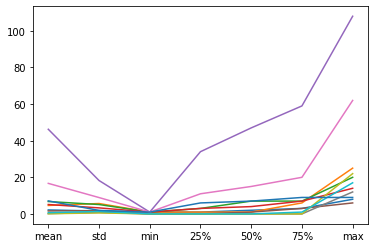

In [41]:
plt.plot(diabetic_no_med_specialty.describe().drop('count', axis=0))

In [45]:
diabetic_med_specialty = diabetic[diabetic['medical_specialty'].notnull()]
diabetic_med_specialty = diabetic_med_specialty.drop(['encounter_id', 'patient_nbr'], axis=1)
diabetic_med_specialty.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000
mean,2.613486,4.794719,6.696165,4.666929,47.225244,1.348318,14.513046,0.077020,0.049041,0.656712,6.768312
std,2.004497,7.351035,4.918415,3.076942,18.046814,1.663772,7.145152,0.418909,0.367843,1.352637,2.051931
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,36.000000,0.000000,9.000000,0.000000,0.000000,0.000000,5.000000
50%,2.000000,1.000000,7.000000,4.000000,48.000000,1.000000,13.000000,0.000000,0.000000,0.000000,7.000000
75%,5.000000,5.000000,7.000000,6.000000,60.000000,2.000000,19.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,25.000000,17.000000,14.000000,114.000000,6.000000,62.000000,7.000000,10.000000,15.000000,9.000000


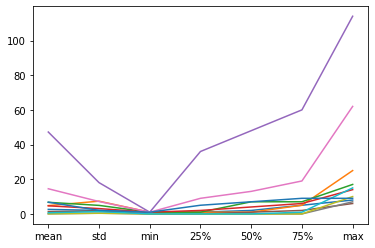

In [46]:
plt.plot(diabetic_med_specialty.describe().drop('count', axis=0))

## Anonymisation

In [82]:
diabetic = diabetic.groupby('patient_nbr', group_keys=False).apply(lambda df: df.sample(1))
diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4780,26264286,135,Caucasian,Female,[50-60),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,>30
5827,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2270,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO
5953,30180318,1152,AfricanAmerican,Female,[50-60),NaN,1,1,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
8926,70190028,1314,Caucasian,Female,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,92021862,115036947,Caucasian,Male,[80-90),NaN,1,22,7,7,...,No,No,No,No,No,No,No,No,Yes,<30
3112,19760178,115042869,Caucasian,Male,[60-70),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2913,18658488,115066152,Caucasian,Female,[80-90),NaN,6,1,17,1,...,No,No,No,No,No,No,No,Ch,Yes,>30
5754,29467458,115187499,AfricanAmerican,Female,[40-50),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [83]:
diabetic_pre = diabetic.copy()

In [165]:
diabetic = diabetic_pre.copy()

## Splitting into train and test

In [149]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(diabetic, diabetic['readmitted']):
    strat_train_set = diabetic.loc[train_index]
    strat_test_set = diabetic.loc[test_index]
    
diabetic_features = strat_train_set.drop("readmitted", axis=1)
diabetic_labels = strat_train_set["readmitted"].copy()

/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


In [122]:
diabetic = diabetic_features

## Preprocessing pipeline

### Numerical and categorical features

In [123]:
list(diabetic.columns)

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [124]:
diabetic_num_features = [
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

diabetic_cat_features = [
 'race',
 'gender',
 'age',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [125]:
class CustomLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, X, y=0):
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        return self.encoder.transform(X)

# class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_bedrooms_per_rooms = True): # note no *args and **kwargs used this time
#         self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X, y=None):
#         rooms_per_household = X[:, rooms_id] / X[:, household_id]
#         bedrooms_per_household = X[:, bedrooms_id] / X[:, household_id]
#         population_per_household = X[:, population_id] / X[:, household_id]
#         if self.add_bedrooms_per_rooms:
#             bedrooms_per_rooms = X[:, bedrooms_id] / X[:, rooms_id]
#             return np.c_[X, rooms_per_household, bedrooms_per_household, 
#                          population_per_household, bedrooms_per_rooms]
#         else:
#             return np.c_[X, rooms_per_household, bedrooms_per_household, 
#                          population_per_household]

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [134]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(diabetic_num_features)),
        ('imputer', SimpleImputer(strategy="median")),
#         ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(diabetic_cat_features)),
        ('imputer', SimpleImputer(strategy="constant")),
#         ('one_hot', OneHotEncoder()),
    ])


full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

diabetic_prepared = full_pipeline.fit_transform(diabetic_features)

In [135]:
diabetic_prepared.shape

(7149, 46)

# Data exploration

In [159]:
diabetic = strat_train_set

In [168]:
diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4780,26264286,135,Caucasian,Female,[50-60),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,>30
5827,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2270,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO
5953,30180318,1152,AfricanAmerican,Female,[50-60),NaN,1,1,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
8926,70190028,1314,Caucasian,Female,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,92021862,115036947,Caucasian,Male,[80-90),NaN,1,22,7,7,...,No,No,No,No,No,No,No,No,Yes,<30
3112,19760178,115042869,Caucasian,Male,[60-70),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2913,18658488,115066152,Caucasian,Female,[80-90),NaN,6,1,17,1,...,No,No,No,No,No,No,No,Ch,Yes,>30
5754,29467458,115187499,AfricanAmerican,Female,[40-50),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [162]:
diabetic_corr = diabetic.corr()
diabetic_corr

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
encounter_id,1.000000,0.001357,-0.200972,-0.276369,0.134493,0.045916,-0.065751,-0.065747,0.031651,0.026543,0.057645,0.096946,0.037620
patient_nbr,0.001357,1.000000,0.201862,-0.183460,0.150255,0.050640,0.102200,-0.009458,0.116742,0.105487,0.067906,0.172802,0.020050
admission_type_id,-0.200972,0.201862,1.000000,0.417156,0.189689,-0.006424,-0.083847,0.033423,0.079574,-0.005338,0.011548,-0.033638,-0.144282
discharge_disposition_id,-0.276369,-0.183460,0.417156,1.000000,-0.110139,0.074513,0.025587,0.017963,0.016699,-0.039578,-0.031710,-0.058946,0.015451
admission_source_id,0.134493,0.150255,0.189689,-0.110139,1.000000,-0.020830,-0.067615,-0.146352,0.000460,0.063387,0.108510,0.014775,0.078379
time_in_hospital,0.045916,0.050640,-0.006424,0.074513,-0.020830,1.000000,0.353399,0.238494,0.500096,-0.022001,-0.011327,0.074051,0.295917
num_lab_procedures,-0.065751,0.102200,-0.083847,0.025587,-0.067615,0.353399,1.000000,0.095932,0.263513,-0.025329,-0.021303,0.018286,0.223002
num_procedures,-0.065747,-0.009458,0.033423,0.017963,-0.146352,0.238494,0.095932,1.000000,0.471391,-0.007534,-0.042808,-0.068411,0.138958
num_medications,0.031651,0.116742,0.079574,0.016699,0.000460,0.500096,0.263513,0.471391,1.000000,0.020407,0.014589,0.042769,0.291943
number_outpatient,0.026543,0.105487,-0.005338,-0.039578,0.063387,-0.022001,-0.025329,-0.007534,0.020407,1.000000,0.165092,0.106637,0.030056


In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

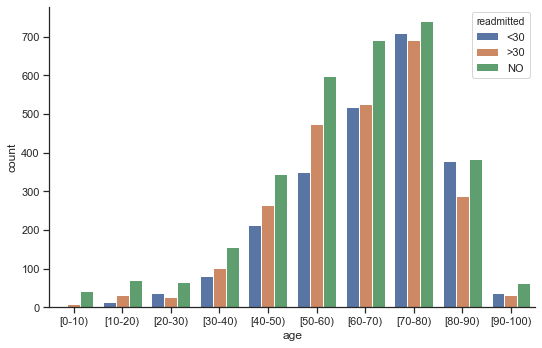

In [234]:
# fig, ax = plt.subplots(figsize=(8, 5))
p1 = sns.catplot(x="age", data=diabetic.sort_values(by=['age', 'readmitted']), hue='readmitted', kind='count', legend_out=False, aspect=1.5)
p1.savefig("report/figures/age_count.png", bbox_inches='tight', dpi=600)

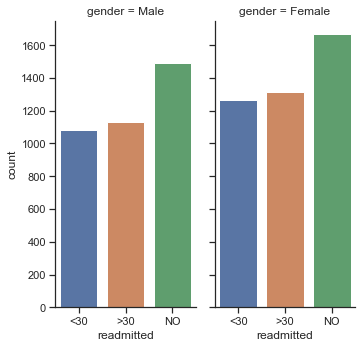

In [218]:
p2 = sns.catplot(x="readmitted", data=diabetic.sort_values(by=['readmitted']), col='gender', kind='count', legend_out=False, aspect=0.5)


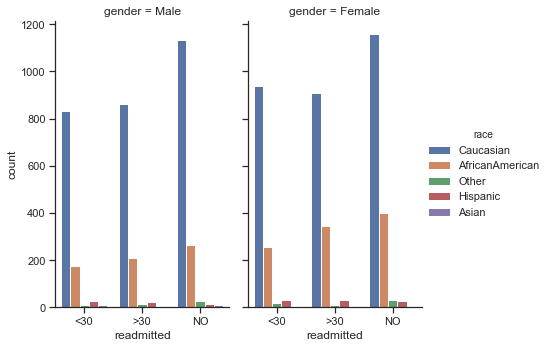

In [224]:
p3 = sns.catplot(x="readmitted", data=diabetic.sort_values(by=['readmitted']), hue='race', col='gender', kind='count', aspect=0.6)

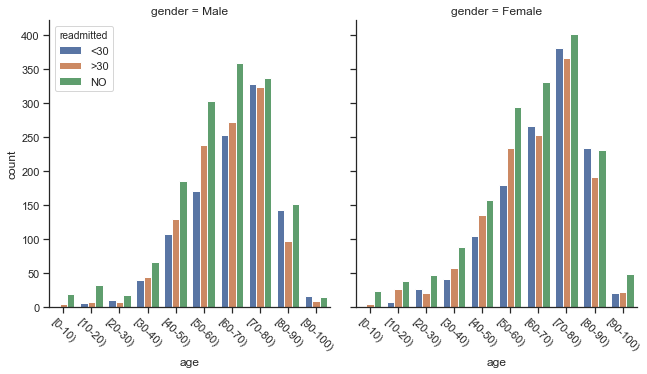

In [252]:
p4 = sns.catplot(x="age", data=diabetic.sort_values(by=['age', 'readmitted']), hue='readmitted', col='gender', kind='count', legend_out=False, aspect=0.9)
p4.set_xticklabels(rotation=-45)
p4.savefig("report/figures/gender_age_count_readmitted.png", bbox_inches='tight', dpi=600)

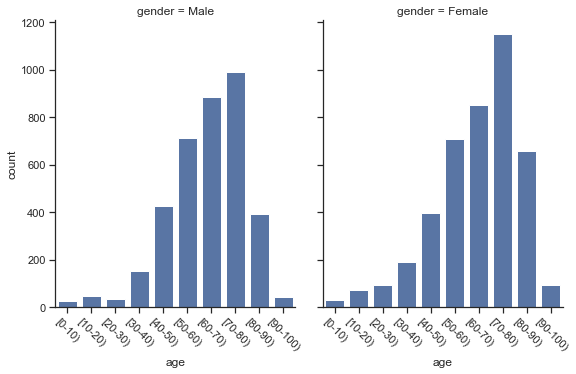

In [251]:
p5 = sns.catplot(x="age", data=diabetic.sort_values(by=['age', 'readmitted']), col='gender', kind='count', color='b', legend_out=False, aspect=0.8)
p5.set_xticklabels(rotation=-45)
p5.savefig("report/figures/gender_age_count.png", bbox_inches='tight', dpi=600)

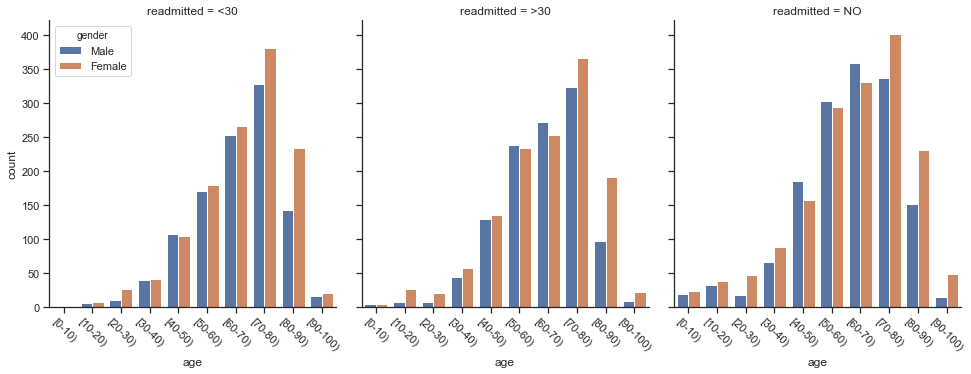

In [243]:
p6 = sns.catplot(x="age", data=diabetic.sort_values(by=['age', 'readmitted']), hue='gender', col='readmitted', kind='count', legend_out=False, aspect=0.9)
p6.set_xticklabels(rotation=-45)
p6.savefig("report/figures/readmitted_by_gender.png", bbox_inches='tight', dpi=600)